(1024, 1024, 3)


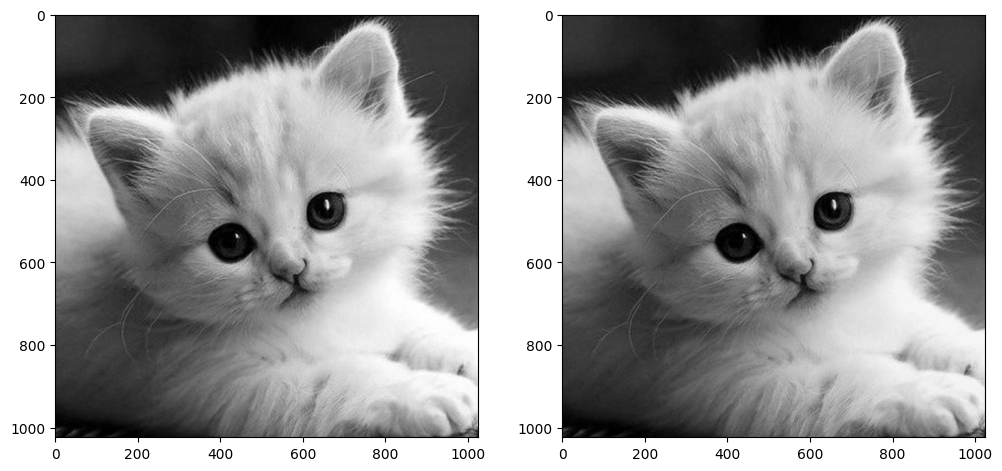

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage import data
from math import pi, cos, sin

# Реализация рекурсивного FFT
def recursive_fft(x):
    n = len(x)
    if n == 1:
        return x
    even = recursive_fft(x[::2]) #разбиваем на четное и нечетное
    odd = recursive_fft(x[1::2])
    w = [np.exp(-2j*pi*k/n)*odd[k] for k in range(n//2)] #задаем степени w
    return [even[k] + w[k] for k in range(n//2)] + [even[k] - w[k] for k in range(n//2)]

# Реализация нерекурсивного FFT
def iterative_fft(x):
    n = len(x)
    if n == 1:
        return x
    bits = int(np.log2(n))
    rev = [int(format(i, '0{}b'.format(bits))[::-1], 2) for i in range(n)]
    x = [x[r] for r in rev]
    x = np.array(x, dtype=np.complex128)

    for s in range(1, bits + 1):
        m = 1 << s
        m_half = m // 2
        w_m = np.exp(-2j * pi / m)

        for k in range(0, n, m):
            w = 1.0
            for j in range(m_half):
                idx_even = k + j
                idx_odd = k + j + m_half
                even = x[idx_even]
                odd = x[idx_odd] * w

                x[idx_even] = even + odd
                x[idx_odd] = even - odd
                w *= w_m
    return x

# Двумерное
def my_fft2(image):
    n, m = image.shape
    size_n = 2**int(np.ceil(np.log2(n))) # Приведение размера к степени двойки
    size_m = 2**int(np.ceil(np.log2(m)))
    padded = np.zeros((size_n, size_m), dtype=complex) #расширяем изображение до полученного размера (потом обрежем)
    padded[:n,:m] = image

    # FFT по строкам
    temp = np.array([iterative_fft(row) for row in padded])

    # FFT по столбцам
    return np.array([iterative_fft(col) for col in temp.T]).T

# Сдвиг частот
def fftshift(fft_img):
    n, m = fft_img.shape
    return np.roll(fft_img, (n//2, m//2), axis=(0,1))
# Обратное
def ifft2(fft_img):
    return np.conj(my_fft2(np.conj(fft_img)))/(fft_img.shape[0]*fft_img.shape[1])


image = skimage.io.imread('./cotique.jpeg')
print(image.shape)
image = rgb2gray(image)  # Переводим в серое чтобы работать с одним каналом (пока)
n, m = image.shape

# Применяем FFT и сдвигаем частоты
fft_image = my_fft2(image.astype(complex))
fshift = fftshift(fft_image)

# Фильтруем частоты
mask_percent = 0.9
crow, ccol = n//2, m//2
mask = np.zeros_like(fshift)
r, c = int(n*mask_percent/2), int(m*mask_percent/2)
mask[crow-r:crow+r, ccol-c:ccol+c] = 1 #маска из 0 и 1 чтобы проредить спектр

filtered = fshift * mask
reconstructed = np.abs(ifft2(fftshift(filtered)))

# Визуализация
plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.subplot(122), plt.imshow(reconstructed, cmap='gray')
plt.show()

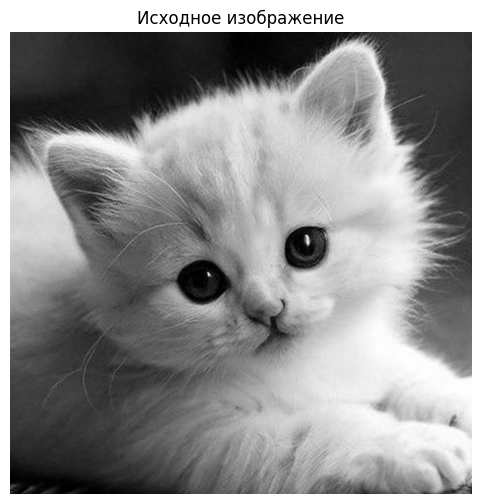

<ipython-input-11-e8e23c19b7c2>:37: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122), plt.imshow(20*np.log(np.abs(filtered_fshift)), cmap='gray')


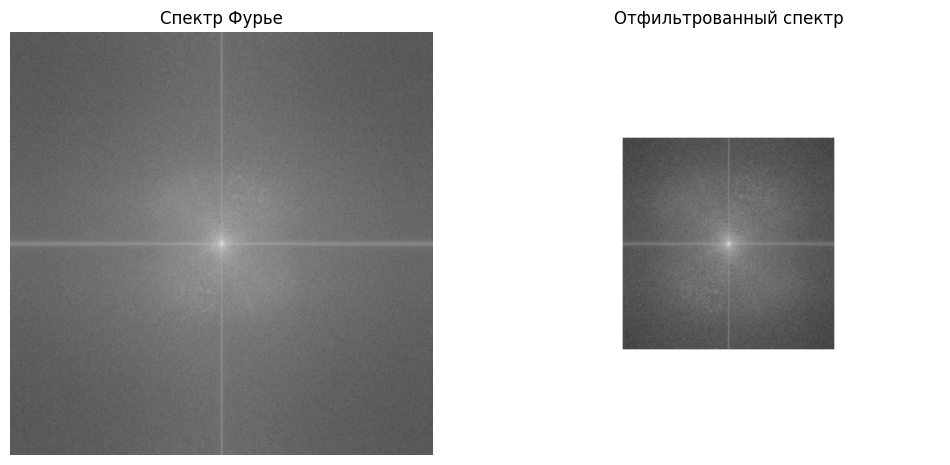

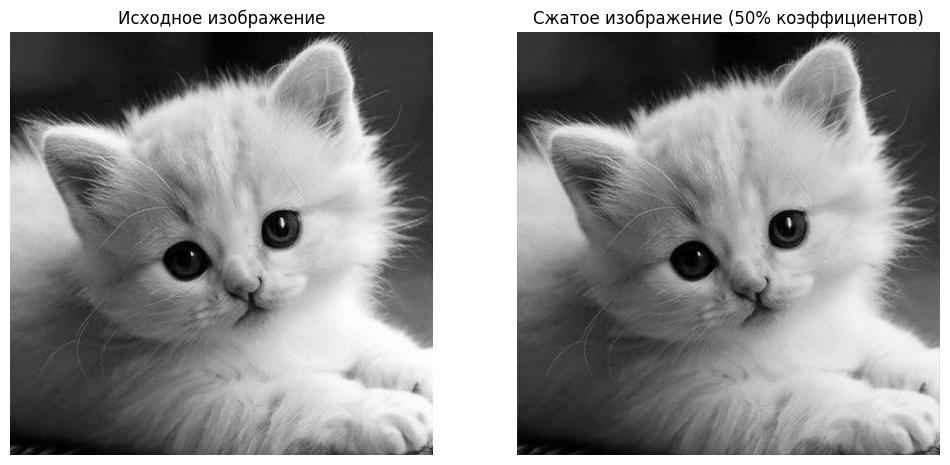

MSE: 0.00007335173364064862
Сжатие: 50% данных удалено


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
import skimage
from skimage import data
from skimage.color import rgb2gray


image = skimage.io.imread('./cotique.jpeg')
image = rgb2gray(image) #data.astronaut()
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

# Применение FFT
fft_image = fft2(image)
fshift = fftshift(fft_image)  # Перенос низких частот в центр

# Визуализация спектра
magnitude_spectrum = 20 * np.log(np.abs(fshift))
plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр Фурье'), plt.axis('off')

# Фильтрация высокочастотных компонент
rows, cols = image.shape
crow, ccol = rows//2, cols//2
mask_percent = 0.5  # Сохраняем 50% центральных коэффициентов
mask = np.zeros((rows, cols), np.uint8)
r = int(rows * mask_percent / 2)
c = int(cols * mask_percent / 2)
mask[crow-r:crow+r, ccol-c:ccol+c] = 1

filtered_fshift = fshift * mask
plt.subplot(122), plt.imshow(20*np.log(np.abs(filtered_fshift)), cmap='gray')
plt.title('Отфильтрованный спектр'), plt.axis('off')
plt.show()

# Обратное преобразование и восстановление изображения
filtered_fft = fftshift(filtered_fshift)
reconstructed_image = np.abs(ifft2(filtered_fft))

plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122), plt.imshow(reconstructed_image, cmap='gray')
plt.title(f'Сжатое изображение ({mask_percent*100:.0f}% коэффициентов)')
plt.axis('off')
plt.show()

# %% [markdown]
# ### 5. Анализ качества сжатия
mse = np.mean((image - reconstructed_image) ** 2)
compression_ratio = (1 - mask_percent) * 100

print(f'MSE: {mse:.20f}')
print(f'Сжатие: {compression_ratio:.0f}% данных удалено')

# %% [markdown]
# ## Выводы
# - FFT позволяет выделить важные частотные компоненты изображения
# - Удаление высокочастотных компонентов дает сжатие с потерями
# - Качество изображения зависит от процента сохраняемых коэффициентов
# - Метод демонстрирует базовый принцип частотного анализа в сжатии

MSE: 0.00002080656777682988
Сжатие: 20% данных удалено
MSE: 0.00007335173364064862
Сжатие: 50% данных удалено
MSE: 0.00028015888850621985
Сжатие: 75% данных удалено
MSE: 0.00094370975527511885
Сжатие: 90% данных удалено


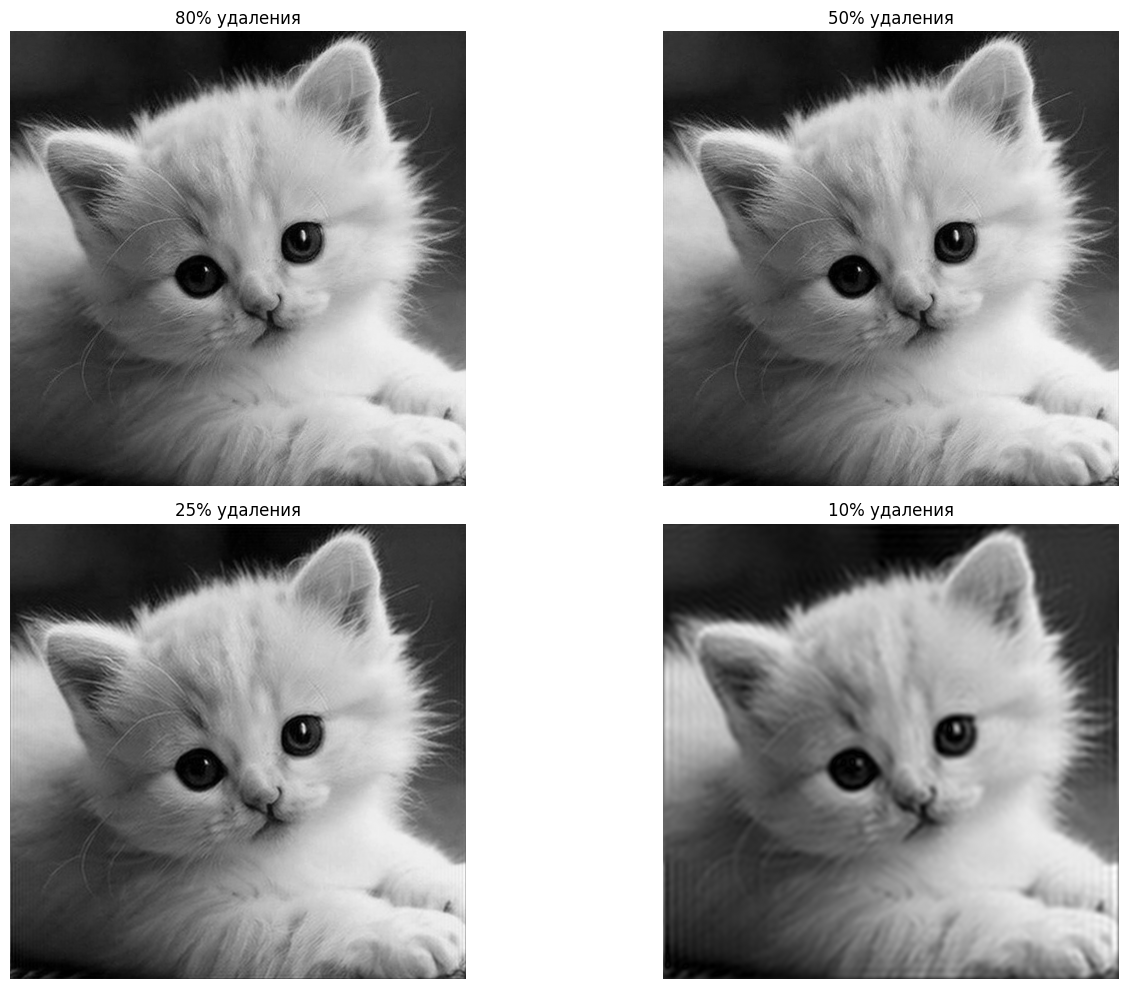

In [12]:
# Эксперименты с разной степенью сжатия
plt.figure(figsize=(15,10))
for i, ratio in enumerate([0.8, 0.5, 0.25, 0.1]):
    mask_percent = ratio  # Сохраняем 50% центральных коэффициентов
    mask = np.zeros((rows, cols), np.uint8)
    r = int(rows * mask_percent / 2)
    c = int(cols * mask_percent / 2)
    mask[crow-r:crow+r, ccol-c:ccol+c] = 1

    filtered_fshift = fshift * mask

    # Обратное преобразование и восстановление изображения
    filtered_fft = fftshift(filtered_fshift)
    reconstructed_image = np.abs(ifft2(filtered_fft))
    mse = np.mean((image - reconstructed_image) ** 2)
    compression_ratio = (1 - mask_percent) * 100

    print(f'MSE: {mse:.20f}')
    print(f'Сжатие: {compression_ratio:.0f}% данных удалено')
    plt.subplot(2,2,i+1)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'{ratio*100:.0f}% удаления')
    plt.axis('off')
plt.tight_layout()
plt.show()

(300, 451, 3)


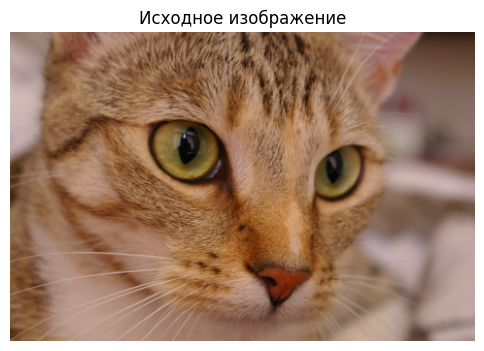

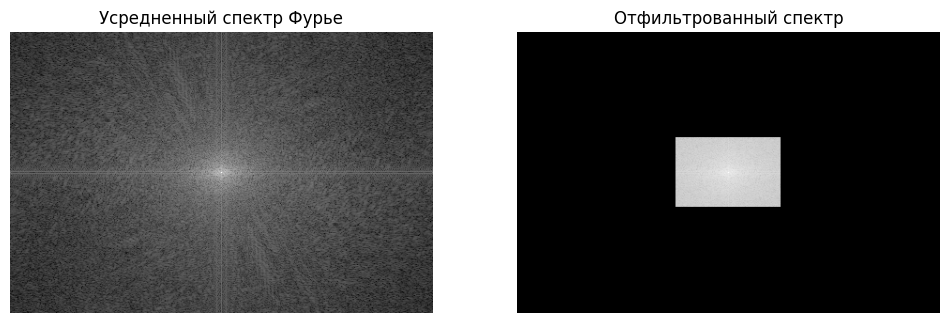

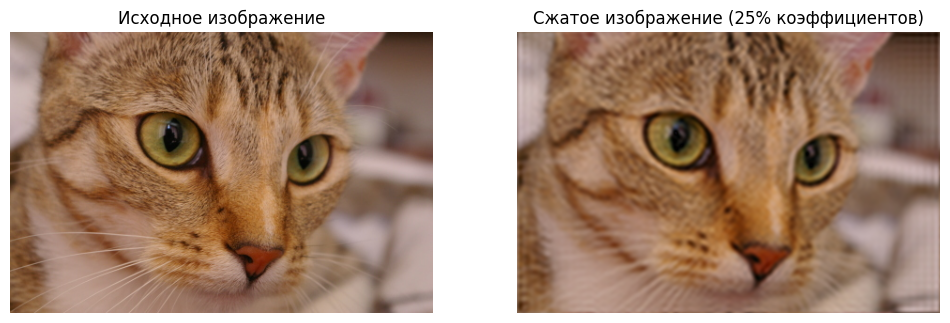

MSE: 61.75
Сжатие: 75% данных удалено


<Figure size 640x480 with 0 Axes>

In [13]:
# Загрузка цветного изображения
image = data.cat()  # Загружаем RGB изображение
print(image.shape)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

# Применение FFT для каждого канала
fft_channels = [fft2(image[:, :, channel]) for channel in range(3)]
fshift_channels = [fftshift(fft) for fft in fft_channels]

# Визуализация спектра (усреднение по каналам)
magnitude_spectrum = np.mean([20*np.log(np.abs(fshift)+1e-10) for fshift in fshift_channels], axis=0)
plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Усредненный спектр Фурье'), plt.axis('off')

# Фильтрация высокочастотных компонент
rows, cols, _ = image.shape
crow, ccol = rows//2, cols//2
mask_percent = 0.25

mask = np.zeros((rows, cols), np.uint8)
r = int(rows * mask_percent / 2)
c = int(cols * mask_percent / 2)
mask[crow-r:crow+r, ccol-c:ccol+c] = 1

filtered_fshift_channels = [fshift * mask for fshift in fshift_channels]
plt.subplot(122), plt.imshow(np.mean([20*np.log(np.abs(fshift)+1e-10) for fshift in filtered_fshift_channels], axis=0), cmap='gray')
plt.title('Отфильтрованный спектр'), plt.axis('off')
plt.show()

# Обратное преобразование и восстановление
filtered_fft_channels = [fftshift(fshift) for fshift in filtered_fshift_channels]
reconstructed_channels = [np.abs(ifft2(fft)) for fft in filtered_fft_channels]

# Сборка цветного изображения и нормализация
reconstructed_image = np.stack(reconstructed_channels, axis=2)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image)
plt.title('Исходное изображение'), plt.axis('off')
plt.subplot(122)
plt.imshow(reconstructed_image)
plt.title(f'Сжатое изображение ({mask_percent*100:.0f}% коэффициентов)')
plt.axis('off')
plt.show()

# Анализ качества сжатия
# Преобразуем исходное изображение к float для расчетов
image_float = image.astype(float)
reconstructed_float = reconstructed_image.astype(float)

mse = np.mean((image_float - reconstructed_float) ** 2)
compression_ratio = (1 - mask_percent) * 100

print(f'MSE: {mse:.2f}')
print(f'Сжатие: {compression_ratio:.0f}% данных удалено')

#plt.figure(figsize=(15,10))
#ratios = [0.95, 0.85, 0.7, 0.5]

plt.tight_layout()
plt.show()


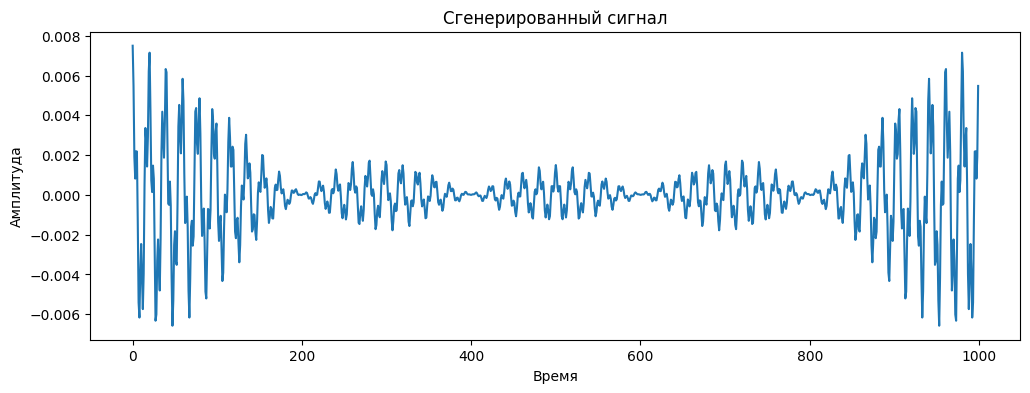

In [14]:
from scipy.fft import ifft, fft, fftfreq
# Создание спектра с заданными частотами
n = 1000
freqs = np.zeros(n)
freqs[50:55] = 1  # 50-55 Hz
freqs[200:205] = 0.5  # 200-205 Hz

# Обратное преобразование
signal = np.real(ifft(freqs))

# Визуализация
plt.figure(figsize=(12,4))
plt.plot(signal)
plt.title('Сгенерированный сигнал')
plt.xlabel('Время')
plt.ylabel('Амплитуда')
plt.show()

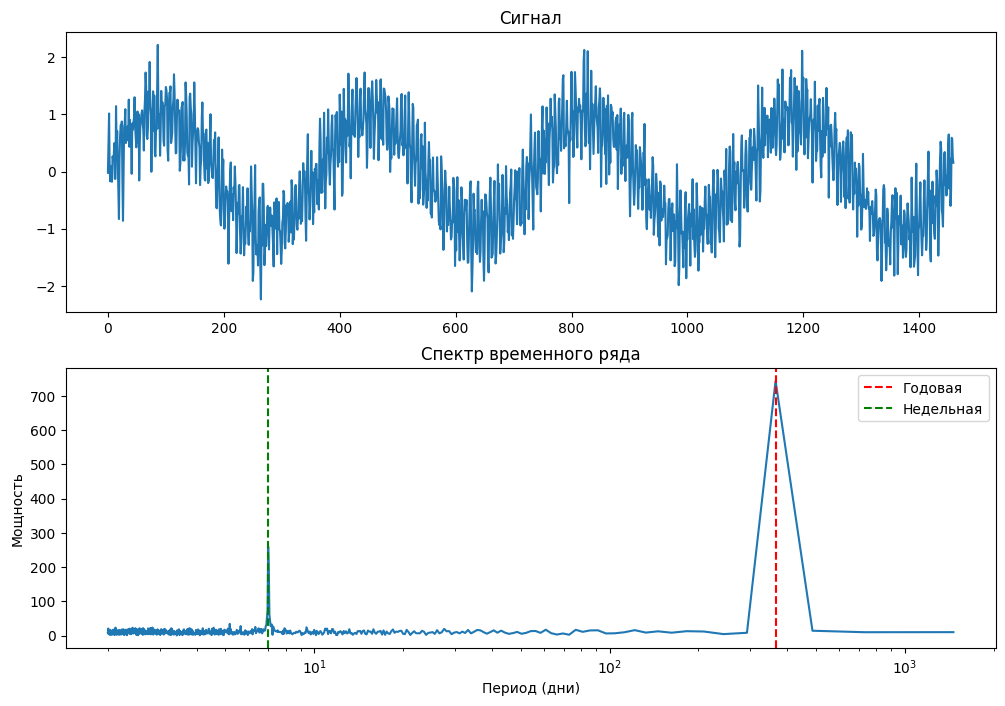

In [15]:
# Генерация данных с сезонностью
t = np.arange(365*4)  # 4 года ежедневных данных
signal = (np.sin(2*np.pi*t/365) +  # Годовая сезонность
          0.5*np.sin(2*np.pi*t/7) +  # Недельная сезонность
          np.random.normal(0, 0.3, len(t)))

# FFT анализ
fft_vals = fft(signal)
freqs = fftfreq(len(t))

# Визуализация доминирующих частот
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.title('Сигнал')
plt.plot(signal)
plt.subplot(212)
plt.plot(1/freqs[1:len(t)//2], np.abs(fft_vals)[1:len(t)//2])
plt.xscale('log')
plt.title('Спектр временного ряда')
plt.xlabel('Период (дни)')
plt.ylabel('Мощность')
plt.axvline(365, c='r', ls='--', label='Годовая')
plt.axvline(7, c='g', ls='--', label='Недельная')
plt.legend()
plt.show()

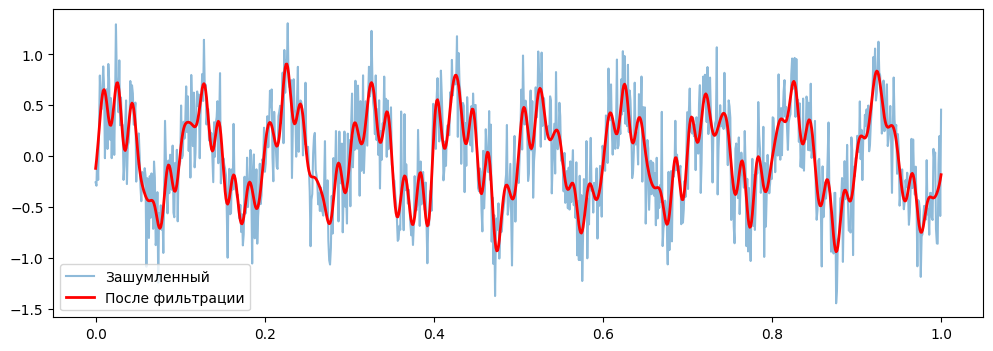

In [16]:
# Генерация зашумленного сигнала
t = np.linspace(0, 1, 1000)
clean = 0.5*np.sin(2*np.pi*10*t) + 0.2*np.sin(2*np.pi*50*t)
noisy = clean + 0.3*np.random.randn(len(t))

# Фильтрация через FFT
fft_signal = fft(noisy)
freqs = fftfreq(len(t), t[1]-t[0])
cutoff = 70  # Отсекаем частоты выше 70 Hz
fft_signal[np.abs(freqs) > cutoff] = 0
filtered = np.real(ifft(fft_signal))

# Визуализация
plt.figure(figsize=(12,4))
plt.plot(t, noisy, alpha=0.5, label='Зашумленный')
plt.plot(t, filtered, 'r', linewidth=2, label='После фильтрации')
plt.legend()
plt.show()

In [ ]:
from scipy.io import wavfile
sample_rate, data = wavfile.read('audio.wav')
...